# Anthropogenic heat from buildings

This notebook is used to process building energy use, analyze data, and ultimately produce the anthropogenic heat flux (AHF) from buildings for the Greater Los Angeles (LA) region.

In [2]:
# load packages 
%matplotlib inline
import os
from pathlib import Path
import zipfile
import pandas as pd
import matplotlib.pyplot as plt
#import requests
import geopandas as gpd
import pyproj
import shapely.geometry

## Import data from data repositories

Download Energy Atlas data from Kaggle repo (if not already in local directory)

In [2]:
energy_atlas_data_path = Path('data/energy_atlas')
if not os.path.isdir(energy_atlas_data_path): # if data directory does not exist (i.e., data not downloaded yet)
    # initialize kaggle API
    from kaggle.api.kaggle_api_extended import KaggleApi
    api = KaggleApi()
    api.authenticate()

    # download from my Kaggle dataset page
    dataset = 'josephko/la-energy-atlas-2016'
    download_path = Path('data/energy_atlas')
    api.dataset_download_files(dataset, download_path) # downloads all data in zip file
    
    # unzip and remove zip file
    zip_file = download_path / 'la-energy-atlas-2016.zip'
    with zipfile.ZipFile(zip_file) as file:
        file.extractall(download_path)
    os.remove(zip_file)


Import Energy Atlas data into dataframes

In [160]:
usage_file = energy_atlas_data_path / 'usage_bld_btu.csv'
usage_bld_btu = pd.read_csv(usage_file, na_values = ['masked'])
#usage_bld_btu = usage_bld_btu.loc[usage_bld_btu['usage'] != 'masked'].copy()

# # TESTING 
# cols = usage_bld_btu.columns.drop(['geo_id', 'usetype', 'name'])
# usage_bld_btu.loc[:,cols] = usage_bld_btu.loc[:, cols].apply(pd.to_numeric, errors = 'coerce')

usage_bld_btu

,geo_id,sqft,usage,usage_med,usage_med_sqft,usetype,year,pct_elec,pct_ng,name,pop,usage_percap
0,cities_1,1253.0,NaN,NaN,NaN,agriculture,2016,NaN,NaN,agoura hills,NaN,NaN
1,cities_1,4820002.0,3.079439e+11,5.522517e+08,46351.2600,commercial,2016,0.729374,0.270626,agoura hills,NaN,NaN
2,cities_1,8916603.0,3.715327e+11,7.530818e+07,34141.0256,condo,2016,0.401412,0.598588,agoura hills,NaN,NaN
3,cities_1,735816.0,NaN,NaN,NaN,industrial,2016,NaN,NaN,agoura hills,NaN,NaN
4,cities_1,100192.0,NaN,NaN,NaN,institutional,2016,NaN,NaN,agoura hills,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
5767,neighborhoods_99,30060.0,NaN,NaN,NaN,residential_other,2016,NaN,NaN,carthay,NaN,NaN
5768,neighborhoods_99,0.0,NaN,NaN,NaN,residential_uncat,2016,NaN,NaN,carthay,NaN,NaN
5769,neighborhoods_99,3452091.0,1.350114e+11,9.211511e+07,35663.1742,res_total,2016,0.325581,0.674419,carthay,5201.0,2.595873e+07
5770,neighborhoods_99,1525718.0,6.178565e+10,7.913064e+07,37415.2632,single_family,2016,0.352719,0.647281,carthay,NaN,NaN


In [161]:
usage_bld_btu.dtypes

geo_id             object
sqft              float64
usage             float64
usage_med         float64
usage_med_sqft    float64
usetype            object
year                int64
pct_elec          float64
pct_ng            float64
name               object
pop               float64
usage_percap      float64
dtype: object

Import geos.csv which has auxiliary information e.g., city names

In [162]:
geos_file = energy_atlas_data_path / 'geos.csv'
geos = pd.read_csv(geos_file, na_values = ['NaN'])
geos

,geo_id,name,pop,pop_sqmi,med_income,pct_own,pct_rent,year,enviroscreen_tracts,sqmi,solar_pot,net_solar_pot,count
0,cogs_5,Westside Cities COG,785154,3929.845670,78816.75,0.051352,0.622423,2010,16.0,199.792579,2.993137e+09,-8888,218333.0
1,cities_39,la habra heights,6310,702.993351,111373.50,0.934310,0.065690,2010,0.0,8.975903,2.343956e+07,-8888,2247.0
2,cities_40,hawaiian gardens,14076,10142.296070,67831.00,0.450913,0.549087,2010,1.0,1.387851,4.271364e+07,-8888,2569.0
3,cities_41,hawthorne,86783,9801.098133,48678.25,0.272886,0.727080,2010,15.0,8.854416,3.889526e+08,-8888,12879.0
4,cities_42,palmdale,148945,947.283953,59654.75,0.675369,0.324607,2010,0.0,157.233741,1.077350e+09,-8888,48080.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
957,cities_4,azusa,45301,3204.573593,59007.00,0.567021,0.432654,2010,4.0,14.136358,2.555376e+08,-8888,-9999.0
958,cities_173,irvine,-7777,-7777.000000,-7777.00,-7777.000000,-7777.000000,2010,0.0,95.894530,NaN,-8888,-7777.0
959,cities_182,newport beach,-7777,-7777.000000,-7777.00,-7777.000000,-7777.000000,2010,0.0,37.307898,NaN,-8888,-7777.0
960,cities_183,orange,-7777,-7777.000000,-7777.00,-7777.000000,-7777.000000,2010,1.0,36.512519,NaN,-8888,-7777.0


Merge consumption data with geos information, and also add additional useful columns

In [163]:
usage_bld = pd.merge(usage_bld_btu, geos, how='left', on = 'geo_id')
usage_bld.columns

Index(['geo_id', 'sqft', 'usage', 'usage_med', 'usage_med_sqft', 'usetype',
       'year_x', 'pct_elec', 'pct_ng', 'name_x', 'pop_x', 'usage_percap',
       'name_y', 'pop_y', 'pop_sqmi', 'med_income', 'pct_own', 'pct_rent',
       'year_y', 'enviroscreen_tracts', 'sqmi', 'solar_pot', 'net_solar_pot',
       'count'],
      dtype='object')

### Import building footpring (LARIAC) and parcels data

Loading the whole LARIAC and parcels datasets takes a lot of memory. 
For now, load sample LARIAC and parcels for the University Park (USC) subset. 

In [22]:
lariac_usc_dir = '/Users/josephko/USC/Research/Anthropogenic Heat/lariac/Countywide_Building_Outlines_2017_usc.geojson'
lariac_usc_df = gpd.read_file(lariac_dir)

<AxesSubplot:>

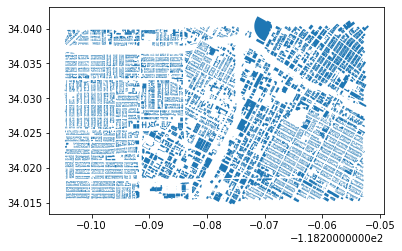

In [23]:
lariac_usc_df.plot()

<AxesSubplot:>

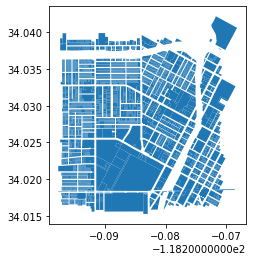

In [24]:
parcels_usc_dir = '/Users/josephko/USC/Research/Anthropogenic Heat/boundaries/LA_County_Parcels_usc.geojson'
parcels_usc_df = gpd.read_file(parcels_dir)
parcels_usc_df.plot()

## Download LA Times Mapping neighborhoods data

In [275]:
neighborhoods.dtypes

external_i      object
name            object
location        object
latitude        object
slug_1          object
sqmi            object
display_na      object
set             object
slug            object
longitude       object
name_1          object
kind            object
type            object
geometry      geometry
dtype: object

<AxesSubplot:>

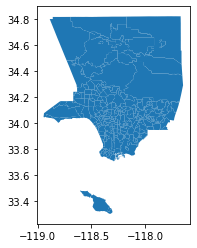

In [274]:
# source: https://usc.data.socrata.com/dataset/Los-Angeles-Neighborhood-Map/r8qd-yxsr
neighborhoods_dir = '/Users/josephko/USC/Research/Anthropogenic Heat/boundaries/la_bound_nbhd.geojson'
neighborhoods = gpd.read_file(neighborhoods_dir)
neighborhoods.plot()

In [52]:
# county_boundary_url = 'https://opendata.arcgis.com/datasets/10f1e37c065347e693cf4e8ee753c09b_15.geojson'
# county_boundary = gpd.read_file(county_boundary_url)
# county_boundary.plot()

In [51]:
# This file contains neighborhoods in Orange County as well. Used file saved on laptop downloaded from website (See above).
# url = 'https://github.com/datadesk/mapping-la-data/raw/main/geojson/la-county-neighborhoods-v6.geojson'
# #file = requests.get(url)
# neighborhoods = gpd.read_file(url)
# neighborhoods.head()

<AxesSubplot:>

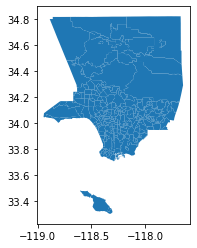

In [61]:
# plot boundaries of neighborhoods for visual check
neighborhoods.plot()

In [62]:
neighborhoods.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [63]:
# Remove Catalina Island (including Avalon) from dataframe
catalina_index = neighborhoods.query('name.str.contains("Catalina") | name.str.contains("Avalon")').index
neighborhoods.drop(catalina_index, inplace=True)

Empty GeoDataFrame
Columns: [external_i, name, location, latitude, slug_1, sqmi, display_na, set, slug, longitude, name_1, kind, type, geometry]
Index: []


<AxesSubplot:>

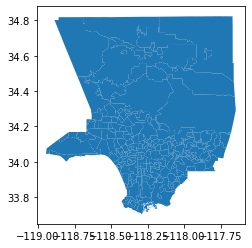

In [69]:
# Check that it was removed
print(neighborhoods.query('name.str.contains("Catalina") | name.str.contains("Avalon")'))
neighborhoods.plot()

In [25]:
#neighborhoods.explore()

## Merge neighborhood boundaries and Energy Atlas data

In [175]:
neighborhoods.head()

,external_i,name,location,latitude,slug_1,sqmi,display_na,set,slug,longitude,name_1,kind,type,geometry
0,acton,Acton,POINT(34.497355239240846 -118.16981019229348),-118.16981019229348,None,39.3391089485,Acton L.A. County Neighborhood (Current),L.A. County Neighborhoods (Current),acton,34.497355239240846,None,L.A. County Neighborhood (Current),unincorporated-area,"MULTIPOLYGON (((-118.20262 34.53899, -118.1894..."
1,adams-normandie,Adams-Normandie,POINT(34.031461499124156 -118.30020800000011),-118.30020800000011,None,0.805350187789,Adams-Normandie L.A. County Neighborhood (Curr...,L.A. County Neighborhoods (Current),adams-normandie,34.031461499124156,None,L.A. County Neighborhood (Current),segment-of-a-city,"MULTIPOLYGON (((-118.30901 34.03741, -118.3004..."
2,agoura-hills,Agoura Hills,POINT(34.146736499122795 -118.75988450000015),-118.75988450000015,None,8.14676029818,Agoura Hills L.A. County Neighborhood (Current),L.A. County Neighborhoods (Current),agoura-hills,34.146736499122795,None,L.A. County Neighborhood (Current),standalone-city,"MULTIPOLYGON (((-118.76193 34.16820, -118.7263..."
3,agua-dulce,Agua Dulce,POINT(34.504926999796837 -118.3171036690717),-118.3171036690717,None,31.4626319451,Agua Dulce L.A. County Neighborhood (Current),L.A. County Neighborhoods (Current),agua-dulce,34.504926999796837,None,L.A. County Neighborhood (Current),unincorporated-area,"MULTIPOLYGON (((-118.25468 34.55830, -118.2555..."
4,alhambra,Alhambra,POINT(34.085538999123571 -118.13651200000021),-118.13651200000021,None,7.62381430605,Alhambra L.A. County Neighborhood (Current),L.A. County Neighborhoods (Current),alhambra,34.085538999123571,None,L.A. County Neighborhood (Current),standalone-city,"MULTIPOLYGON (((-118.12175 34.10504, -118.1168..."


In [176]:
usage_bld_btu

,geo_id,sqft,usage,usage_med,usage_med_sqft,usetype,year,pct_elec,pct_ng,name,pop,usage_percap
0,cities_1,1253.0,NaN,NaN,NaN,agriculture,2016,NaN,NaN,agoura hills,NaN,NaN
1,cities_1,4820002.0,3.079439e+11,5.522517e+08,46351.2600,commercial,2016,0.729374,0.270626,agoura hills,NaN,NaN
2,cities_1,8916603.0,3.715327e+11,7.530818e+07,34141.0256,condo,2016,0.401412,0.598588,agoura hills,NaN,NaN
3,cities_1,735816.0,NaN,NaN,NaN,industrial,2016,NaN,NaN,agoura hills,NaN,NaN
4,cities_1,100192.0,NaN,NaN,NaN,institutional,2016,NaN,NaN,agoura hills,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
5767,neighborhoods_99,30060.0,NaN,NaN,NaN,residential_other,2016,NaN,NaN,carthay,NaN,NaN
5768,neighborhoods_99,0.0,NaN,NaN,NaN,residential_uncat,2016,NaN,NaN,carthay,NaN,NaN
5769,neighborhoods_99,3452091.0,1.350114e+11,9.211511e+07,35663.1742,res_total,2016,0.325581,0.674419,carthay,5201.0,2.595873e+07
5770,neighborhoods_99,1525718.0,6.178565e+10,7.913064e+07,37415.2632,single_family,2016,0.352719,0.647281,carthay,NaN,NaN


In [177]:
neighborhoods_lower = neighborhoods.copy()
neighborhoods_lower['name'] = neighborhoods_lower['name'].str.lower()
neighborhoods_lower.head()

,external_i,name,location,latitude,slug_1,sqmi,display_na,set,slug,longitude,name_1,kind,type,geometry
0,acton,acton,POINT(34.497355239240846 -118.16981019229348),-118.16981019229348,None,39.3391089485,Acton L.A. County Neighborhood (Current),L.A. County Neighborhoods (Current),acton,34.497355239240846,None,L.A. County Neighborhood (Current),unincorporated-area,"MULTIPOLYGON (((-118.20262 34.53899, -118.1894..."
1,adams-normandie,adams-normandie,POINT(34.031461499124156 -118.30020800000011),-118.30020800000011,None,0.805350187789,Adams-Normandie L.A. County Neighborhood (Curr...,L.A. County Neighborhoods (Current),adams-normandie,34.031461499124156,None,L.A. County Neighborhood (Current),segment-of-a-city,"MULTIPOLYGON (((-118.30901 34.03741, -118.3004..."
2,agoura-hills,agoura hills,POINT(34.146736499122795 -118.75988450000015),-118.75988450000015,None,8.14676029818,Agoura Hills L.A. County Neighborhood (Current),L.A. County Neighborhoods (Current),agoura-hills,34.146736499122795,None,L.A. County Neighborhood (Current),standalone-city,"MULTIPOLYGON (((-118.76193 34.16820, -118.7263..."
3,agua-dulce,agua dulce,POINT(34.504926999796837 -118.3171036690717),-118.3171036690717,None,31.4626319451,Agua Dulce L.A. County Neighborhood (Current),L.A. County Neighborhoods (Current),agua-dulce,34.504926999796837,None,L.A. County Neighborhood (Current),unincorporated-area,"MULTIPOLYGON (((-118.25468 34.55830, -118.2555..."
4,alhambra,alhambra,POINT(34.085538999123571 -118.13651200000021),-118.13651200000021,None,7.62381430605,Alhambra L.A. County Neighborhood (Current),L.A. County Neighborhoods (Current),alhambra,34.085538999123571,None,L.A. County Neighborhood (Current),standalone-city,"MULTIPOLYGON (((-118.12175 34.10504, -118.1168..."


In [200]:
usage_bld = neighborhoods_lower.merge(usage_bld_btu, on='name')
usage_bld.columns

Index(['external_i', 'name', 'location', 'latitude', 'slug_1', 'sqmi',
       'display_na', 'set', 'slug', 'longitude', 'name_1', 'kind', 'type',
       'geometry', 'geo_id', 'sqft', 'usage', 'usage_med', 'usage_med_sqft',
       'usetype', 'year', 'pct_elec', 'pct_ng', 'pop', 'usage_percap'],
      dtype='object')

In [201]:
# clean up dataframe, drop unnecessary columns
cols_drop = ['external_i','slug_1','display_na', 'set', 'name_1']
usage_bld.drop(cols_drop, axis=1, inplace=True)
usage_bld.columns

Index(['name', 'location', 'latitude', 'sqmi', 'slug', 'longitude', 'kind',
       'type', 'geometry', 'geo_id', 'sqft', 'usage', 'usage_med',
       'usage_med_sqft', 'usetype', 'year', 'pct_elec', 'pct_ng', 'pop',
       'usage_percap'],
      dtype='object')

In [206]:
# add column for usage in units of Watts (1 btu = 0.293 watts)
usage_bld['usage_watts'] = usage_bld['usage']*0.293

<AxesSubplot:>

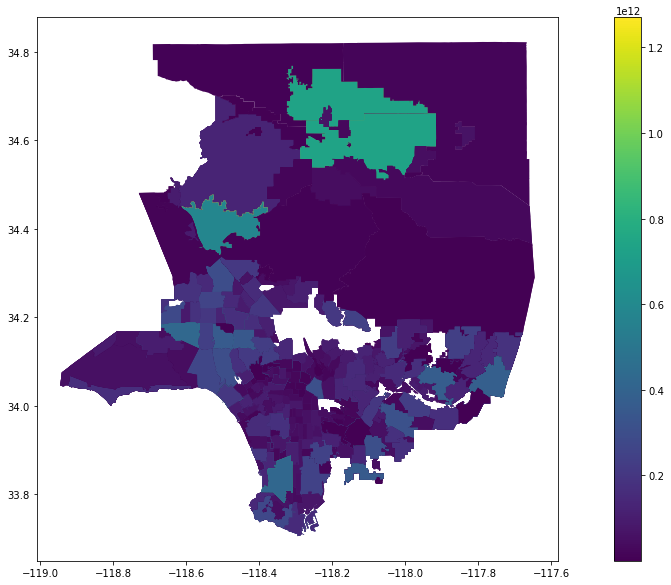

In [207]:
usage_bld.plot(column='usage_watts', legend=True, figsize=(20,10))

## Descriptive analysis of Energy Atlas data

In [164]:
# How many different usetype categories?
usage_bld_btu['usetype'].unique()

array(['agriculture', 'commercial', 'condo', 'industrial',
       'institutional', 'multi_family', 'other', 'residential_other',
       'residential_uncat', 'res_total', 'single_family', 'uncat'],
      dtype=object)

In [165]:
# subset only neighborhood-aggregated records
usage_bld_btu_neighborhoods = usage_bld_btu.loc[usage_bld_btu['geo_id'].str.contains('neighborhoods')].copy()
usage_bld_btu_neighborhoods

,geo_id,sqft,usage,usage_med,usage_med_sqft,usetype,year,pct_elec,pct_ng,name,pop,usage_percap
2508,neighborhoods_100,NaN,NaN,NaN,NaN,agriculture,2016,NaN,NaN,castaic,NaN,NaN
2509,neighborhoods_100,554997.0,NaN,NaN,NaN,commercial,2016,NaN,NaN,castaic,NaN,NaN
2510,neighborhoods_100,50416.0,1.745402e+10,1.677837e+08,99221.5579,condo,2016,0.435955,0.564045,castaic,NaN,NaN
2511,neighborhoods_100,44121.0,NaN,NaN,NaN,industrial,2016,NaN,NaN,castaic,NaN,NaN
2512,neighborhoods_100,17252.0,NaN,NaN,NaN,institutional,2016,NaN,NaN,castaic,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
5767,neighborhoods_99,30060.0,NaN,NaN,NaN,residential_other,2016,NaN,NaN,carthay,NaN,NaN
5768,neighborhoods_99,0.0,NaN,NaN,NaN,residential_uncat,2016,NaN,NaN,carthay,NaN,NaN
5769,neighborhoods_99,3452091.0,1.350114e+11,9.211511e+07,35663.1742,res_total,2016,0.325581,0.674419,carthay,5201.0,2.595873e+07
5770,neighborhoods_99,1525718.0,6.178565e+10,7.913064e+07,37415.2632,single_family,2016,0.352719,0.647281,carthay,NaN,NaN


In [166]:
# How many unique neighborhoods?
len(usage_bld_btu_neighborhoods['geo_id'].unique())

272

In [167]:
# further subset for only residential
usage_bld_btu_neighborhoods_res = usage_bld_btu_neighborhoods.loc[usage_bld_btu_neighborhoods['usetype'] == 'res_total'].copy()
usage_bld_btu_neighborhoods_res

,geo_id,sqft,usage,usage_med,usage_med_sqft,usetype,year,pct_elec,pct_ng,name,pop,usage_percap
2517,neighborhoods_100,10257155.0,4.076383e+11,6.796309e+07,34019.6952,res_total,2016,0.420110,0.579890,castaic,16843.0,2.420224e+07
2529,neighborhoods_101,16985227.0,7.236221e+11,7.088365e+07,27792.0387,res_total,2016,0.431834,0.568166,castaic canyons,46516.0,1.555641e+07
2541,neighborhoods_102,7467333.0,3.477981e+11,6.447685e+07,42876.8815,res_total,2016,0.306654,0.693346,central-alameda,43628.0,7.971901e+06
2553,neighborhoods_103,1691063.0,3.436476e+11,8.125534e+07,39514.2308,res_total,2016,0.379314,0.620686,century city,5516.0,6.230015e+07
2565,neighborhoods_104,NaN,NaN,NaN,NaN,res_total,2016,NaN,NaN,cerritos,49956.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
5721,neighborhoods_95,NaN,NaN,NaN,NaN,res_total,2016,NaN,NaN,burbank,104565.0,NaN
5733,neighborhoods_96,19994907.0,9.702669e+11,9.399458e+07,34430.9786,res_total,2016,0.405001,0.594999,calabasas,25656.0,3.781832e+07
5745,neighborhoods_97,18630293.0,9.789736e+11,6.674304e+07,44255.3542,res_total,2016,0.421667,0.578333,canoga park,61801.0,1.584074e+07
5757,neighborhoods_98,30620822.0,1.376155e+12,4.847913e+07,32486.7605,res_total,2016,0.353819,0.646181,carson,92200.0,1.492576e+07


In [168]:
print(usage_bld_btu_neighborhoods_res._is_copy)

None


In [169]:
# testing SettingWithCopyWarning with test df
df = pd.DataFrame({'A': ['1', '2', 'NaN'], 'B': ['1', 'NaN', '3'], 'C': ['1', '2', '3']})
cols = df.columns.drop(['C'])
df.loc[:, cols] = df[cols].apply(pd.to_numeric, errors = 'coerce')
df

,A,B,C
0,1.0,1.0,1
1,2.0,NaN,2
2,NaN,3.0,3


In [170]:
# convert appropriate columns to numeric
cols = usage_bld_btu_neighborhoods_res.columns.drop(['geo_id', 'usetype', 'name'])
usage_bld_btu_neighborhoods_res.loc[:,cols] = usage_bld_btu_neighborhoods_res[cols].apply(pd.to_numeric, errors = 'coerce')
usage_bld_btu_neighborhoods_res.dtypes

geo_id             object
sqft              float64
usage             float64
usage_med         float64
usage_med_sqft    float64
usetype            object
year                int64
pct_elec          float64
pct_ng            float64
name               object
pop               float64
usage_percap      float64
dtype: object

<AxesSubplot:ylabel='Frequency'>

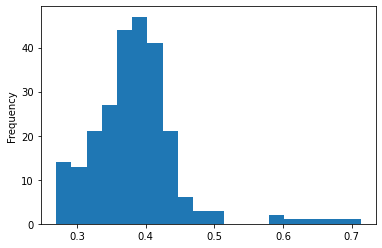

In [171]:
# distribution of pct_elec
# usage_bld_btu_neighborhoods_res['pct_elec'] = pd.to_numeric(usage_bld_btu_neighborhoods_res['pct_elec'])
usage_bld_btu_neighborhoods_res['pct_elec'].plot.hist(bins = 20) 

<AxesSubplot:ylabel='Frequency'>

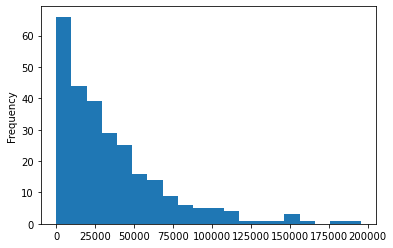

In [172]:
# distribution of pop
usage_bld_btu_neighborhoods_res['pop'].plot.hist(bins = 20) 

<AxesSubplot:ylabel='Frequency'>

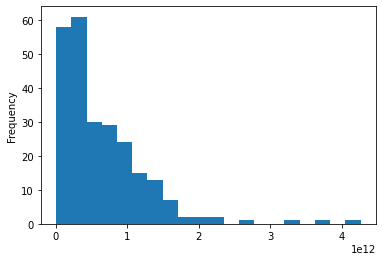

In [173]:
# distribution of usage
usage_bld_btu_neighborhoods_res['usage'].plot.hist(bins = 20) 

<AxesSubplot:ylabel='Frequency'>

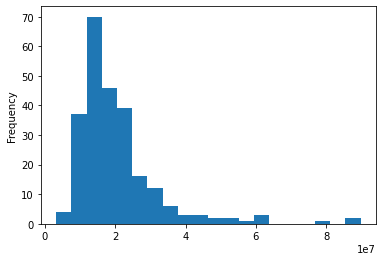

In [174]:
# distribution of usage per capita
usage_bld_btu_neighborhoods_res['usage_percap'].plot.hist(bins = 20) 

## Create 2d grid

In [130]:
"""
example references:
https://james-brennan.github.io/posts/fast_gridding_geopandas/
https://stackoverflow.com/questions/40342355/how-can-i-generate-a-regular-geographic-grid-using-python
"""

# create grid that covers the extent of LA County, set at 'X' m resolution
xmin, ymin, xmax, ymax= neighborhoods.total_bounds

# Set up transformers, EPSG:3857 is metric, same as EPSG:900913
to_proxy_transformer = pyproj.Transformer.from_crs('epsg:4326', 'epsg:3857', always_xy=True)
to_original_transformer = pyproj.Transformer.from_crs('epsg:4326', 'epsg:3857', always_xy=True)

# Create corners of rectangle to be transformed to a grid
sw = shapely.geometry.Point((xmin, ymin))
ne = shapely.geometry.Point((xmax, ymax))

stepsize = 1000 # grid resolution in meters

# Project corners to target projection
transformed_sw = to_proxy_transformer.transform(sw.x, sw.y) # Transform NW point to 3857
transformed_ne = to_proxy_transformer.transform(ne.x, ne.y) # .. same for SE



In [133]:
print(xmin, ymin, xmax, ymax)

-118.94486418867147 33.70453798214502 -117.64560400000032 34.82316790057429


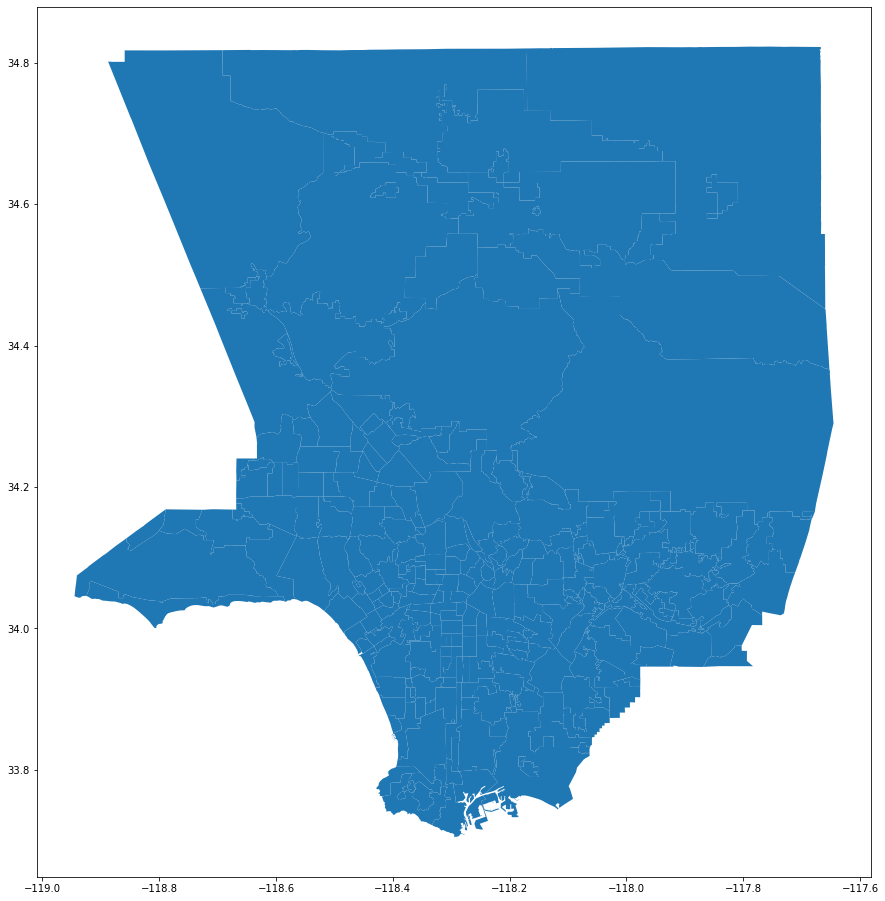

In [132]:
# Iterate over 2D area
grid_cells = []
x = transformed_sw[0]
while x < transformed_ne[0]:
    y = transformed_sw[1]
    while y < transformed_ne[1]:
        x1 = x + stepsize
        y1 = y + stepsize
        cell = shapely.geometry.box(x, y, x1, y1)
        grid_cells.append(cell)
        y += stepsize
    x += stepsize


ah_grid = gpd.GeoDataFrame(grid_cells, columns=['geometry'], crs='epsg:3857')
ah_grid = ah_grid.to_crs('epsg:4326')

ax = neighborhoods.plot(figsize=(24, 16))
plt.autoscale(False)
#ah_grid.plot(ax=ax, facecolor="none", edgecolor='grey')

## Create Residential Dataset

### Proof of concept: University Park neighborhood


In [219]:
import contextily as ctx

In [266]:
top_row = usage_usc.head(1)
top_row

,name,location,latitude,sqmi,slug,longitude,kind,type,geometry,geo_id,...,usage,usage_med,usage_med_sqft,usetype,year,pct_elec,pct_ng,pop,usage_percap,usage_watts
3777,university park,POINT(34.028113999124287 -118.28280750000005),-118.28280750000005,1.16714354652,university-park,34.028113999124287,L.A. County Neighborhood (Current),segment-of-a-city,"MULTIPOLYGON (((-118.28282 34.01842, -118.2915...",neighborhoods_296,...,2.521718e+11,9.962047e+07,34292.2159,res_total,2016,0.444748,0.555252,24834.0,1.015430e+07,7.388634e+10


In [276]:
pd.to_numeric(top_row['latitude'])

3777   -118.282808
Name: latitude, dtype: float64

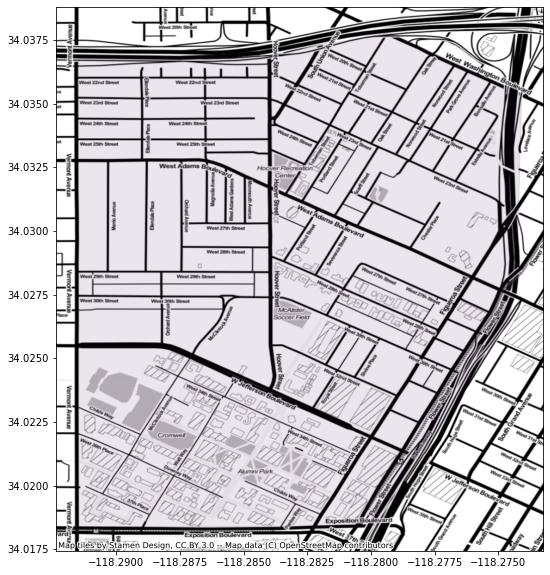

In [280]:
# get usage for university park neighborhood only
usage_usc = usage_bld[(usage_bld['name'] == 'university park') & (usage_bld['usetype'] == 'res_total')]
#usage_usc = usage_bld[usage_bld['usetype'] == 'res_total']
ax = usage_usc.plot(figsize=(10,10), column = 'usage_watts', alpha=0.1, edgecolor='k')
ax.get_xaxis().get_major_formatter().set_useOffset(False)
#ax.annotate(usage_usc.iloc[0].usage_watts, xy=[pd.to_numeric(top_row['latitude']), pd.to_numeric(top_row['longitude'])])
ctx.add_basemap(ax, source=ctx.providers.Stamen.Toner, crs=usage_bld.crs) # notice the crs must match between basemap and data

<AxesSubplot:>

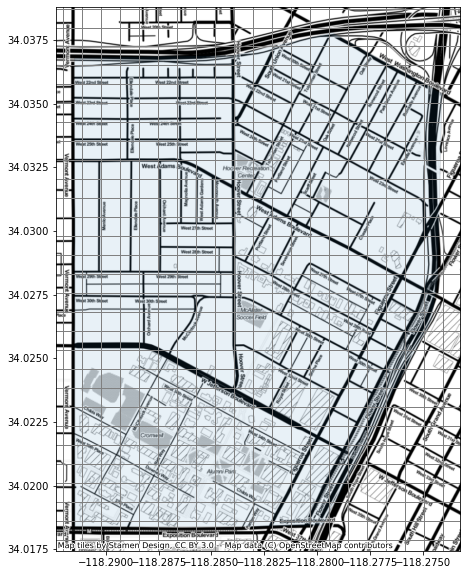

In [282]:
# create 2d grid
"""
example references:
https://james-brennan.github.io/posts/fast_gridding_geopandas/
https://stackoverflow.com/questions/40342355/how-can-i-generate-a-regular-geographic-grid-using-python
"""

# create grid that covers the extent of LA County, set at 'X' m resolution
xmin, ymin, xmax, ymax = usage_usc.total_bounds

# create a little buffer for extent
xmin = xmin - 0.005
ymin = ymin - 0.005
xmax = xmax + 0.005
ymax = ymax + 0.005

# Set up transformers, EPSG:3857 is metric, same as EPSG:900913
to_proxy_transformer = pyproj.Transformer.from_crs('epsg:4326', 'epsg:3857', always_xy=True)
to_original_transformer = pyproj.Transformer.from_crs('epsg:4326', 'epsg:3857', always_xy=True)

# Create corners of rectangle to be transformed to a grid
sw = shapely.geometry.Point((xmin, ymin))
ne = shapely.geometry.Point((xmax, ymax))

stepsize = 100 # grid resolution in meters

# Project corners to target projection
transformed_sw = to_proxy_transformer.transform(sw.x, sw.y) # Transform NW point to 3857
transformed_ne = to_proxy_transformer.transform(ne.x, ne.y) # .. same for SE

# Iterate over 2D area
grid_cells = []
x = transformed_sw[0]
while x < transformed_ne[0]:
    y = transformed_sw[1]
    while y < transformed_ne[1]:
        x1 = x + stepsize
        y1 = y + stepsize
        cell = shapely.geometry.box(x, y, x1, y1)
        grid_cells.append(cell)
        y += stepsize
    x += stepsize


ah_grid = gpd.GeoDataFrame(grid_cells, columns=['geometry'], crs='epsg:3857')
ah_grid = ah_grid.to_crs('epsg:4326')

ax = usage_usc.plot(figsize=(10,10), alpha=0.1, edgecolor='k')
ax.get_xaxis().get_major_formatter().set_useOffset(False)
ctx.add_basemap(ax, source=ctx.providers.Stamen.Toner, crs=usage_bld.crs) # notice the crs must match between basemap and data
ah_grid.plot(ax=ax, facecolor="none", edgecolor='grey')

In [13]:
# spatial join LARIAC and parcels dataframe
parcels_usc_res_df = parcels_usc_df[parcels_usc_df['UseType'] == 'Residential'] # filter for only residential


In [26]:
lariac_usc_df.head()

,OBJECTID,CODE,BLD_ID,HEIGHT,ELEV,SOURCE,DATE_,STATUS,OLD_BLD_ID,AREA,SHAPE_Length,SHAPE_Area,geometry
0,957685,Building,483673833865,14.95,245.72,LARIAC2,2008,Unchanged,None,1006.365277,0.000402,9.126901e-09,"MULTIPOLYGON (((-118.25750 34.03125, -118.2574..."
1,957686,Building,483520833903,19.84,249.99,LARIAC2,2008,Unchanged,None,4992.681203,0.000904,4.527950e-08,"MULTIPOLYGON (((-118.25791 34.03130, -118.2579..."
2,957687,Building,483571833889,16.37,246.91,LARIAC2,2008,Unchanged,None,3313.375002,0.000706,3.004969e-08,"MULTIPOLYGON (((-118.25765 34.03138, -118.2577..."
3,957688,Building,483660833714,12.57,242.47,LARIAC2,2008,Unchanged,None,508.325913,0.000293,4.610117e-09,"MULTIPOLYGON (((-118.25750 34.03091, -118.2575..."
4,957689,Building,483662833743,19.97,252.37,LARIAC2,2008,Unchanged,None,49.226259,0.000087,4.464431e-10,"MULTIPOLYGON (((-118.25746 34.03096, -118.2574..."


In [27]:
parcels_usc_df.columns

Index(['OBJECTID', 'AIN', 'APN', 'SitusHouse', 'SitusFract', 'SitusDirec',
       'SitusUnit', 'SitusStree', 'SitusAddre', 'SitusCity', 'SitusZIP',
       'SitusFullA', 'TaxRateAre', 'TaxRateCit', 'AgencyClas', 'AgencyName',
       'AgencyType', 'UseCode', 'UseCode_2', 'UseType', 'UseDescrip',
       'DesignType', 'YearBuilt1', 'EffectiveY', 'Units1', 'Bedrooms1',
       'Bathrooms1', 'SQFTmain1', 'DesignTy_1', 'YearBuilt2', 'Effectiv_1',
       'Units2', 'Bedrooms2', 'Bathrooms2', 'SQFTmain2', 'DesignTy_2',
       'YearBuilt3', 'Effectiv_2', 'Units3', 'Bedrooms3', 'Bathrooms3',
       'SQFTmain3', 'DesignTy_3', 'YearBuilt4', 'Effectiv_3', 'Units4',
       'Bedrooms4', 'Bathrooms4', 'SQFTmain4', 'DesignTy_4', 'YearBuilt5',
       'Effectiv_4', 'Units5', 'Bedrooms5', 'Bathrooms5', 'SQFTmain5',
       'Roll_Year', 'Roll_LandV', 'Roll_ImpVa', 'Roll_PersP', 'Roll_Fixtu',
       'Roll_HomeO', 'Roll_RealE', 'Roll_Per_1', 'Roll_Fix_1', 'Roll_LandB',
       'Roll_ImpBa', 'SpatialCha', 'ParcelC

In [28]:
parcels_usc_df.shape

(3203, 92)

In [30]:
parcels_usc_res_df = parcels_usc_df[parcels_usc_df['UseType'] == 'Residential']
parcels_usc_res_df.head()

,OBJECTID,AIN,APN,SitusHouse,SitusFract,SitusDirec,SitusUnit,SitusStree,SitusAddre,SitusCity,...,LegalDes_5,LegalDescr,CENTER_LAT,CENTER_LON,CENTER_X,CENTER_Y,LAT_LON,ShapeSTAre,ShapeSTLen,geometry
11,12279,5120003003,5120-003-003,3212,None,S,None,MAIN ST,3212 S MAIN ST,LOS ANGELES CA,...,TRACT EX OF ST LOT 3,F D LANTERMAN'S SUB OF THE MAUDSLEY TRACT EX O...,34.019731,-118.271507,6.479392e+06,1.829674e+06,"34.019731, -118.271507",6497.456055,359.962589,"MULTIPOLYGON (((-118.27129 34.01971, -118.2713..."
15,13345,5122002018,5122-002-018,160,None,W,None,27TH ST,160 W 27TH ST,LOS ANGELES CA,...,None,WALKER TRACT LOT 37,34.024429,-118.271348,6.479445e+06,1.831383e+06,"34.024429, -118.271348",6254.959961,357.006895,"MULTIPOLYGON (((-118.27119 34.02456, -118.2713..."
16,13346,5122012009,5122-012-009,222,None,W,None,27TH ST,222 W 27TH ST,LOS ANGELES CA,...,None,WALKER TRACT LOT 42,34.024738,-118.272046,6.479234e+06,1.831497e+06,"34.024738, -118.272046",6180.691406,353.955058,"MULTIPOLYGON (((-118.27189 34.02487, -118.2720..."
22,13364,5123004430,5123-004-430,973,None,W,112,30TH ST,973 W 30TH ST 112,LOS ANGELES CA,...,None,TR=47011 LOT 1 CONDO UNIT 112,34.027836,-118.283437,6.475785e+06,1.832633e+06,"34.027836, -118.283437",43572.224609,908.664176,"MULTIPOLYGON (((-118.28354 34.02816, -118.2833..."
23,13365,5123004436,5123-004-436,971,None,W,118,30TH ST,971 W 30TH ST 118,LOS ANGELES CA,...,None,TR=47011 LOT 1 CONDO UNIT 118,34.027836,-118.283437,6.475785e+06,1.832633e+06,"34.027836, -118.283437",43572.224609,908.664176,"MULTIPOLYGON (((-118.28354 34.02816, -118.2833..."
